In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter, convolve

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy

import xarray as xr
import glob
import time
from xarray.ufuncs import cos, deg2rad

In [3]:
def mean_era5(year1,year2,varid,mnth=""):
    """Compute the monthly climatology of a 3D or 4D ERA5 variable for years between year1 and year2 (included),
    year1/2 must be of the type "yyyy"
    varid gives the id of the variable in era5, e.g. '128_135_w' for omega
    mnth is an str that gives the month to be considered
    """
    path = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"
    
    era5varsum = 0
    count = int(year2)+1-int(year1)
    era5varlist = []
    for y in [str(year) for year in range(int(year1),int(year2)+1)]:
        era5var = xr.open_dataset(glob.glob(path+"*/e5.*.%s.*.%s*.nc"%(varid,y))[0])
        varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'W' for omega
        if len(mnth)>0:
            era5var1 = era5var[varname].sel(time=pd.to_datetime(y+mnth,format='%Y%m'))
        else :
            era5var1 = era5var[varname].mean("time")
        era5varsum += era5var1
        era5varlist.append(era5var1)
    #climatology = xr.concat(era5varlist,"time").groupby("time.month").mean("time")
    return era5varsum/count#climatology#

In [9]:
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"

#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog = orog.differentiate("latitude")/m_per_degreelat

In [4]:
#PRECIP, PW, U&V
pr_trmm=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr*3600*24
pr_trmm_mean07 = pr_trmm.sel(time=(pr_trmm['time.month']==7)).mean('time').rename({'lat': 'latitude','lon': 'longitude'})

pw_era5_mean07 = mean_era5("2010","2013",'128_137_tcwv',mnth="")

u100m_era5_mean07 = mean_era5("2010","2013",'228_246_100u',mnth="07")
v100m_era5_mean07 = mean_era5("2010","2013",'228_247_100v',mnth="07")

upslope_w_era5_07 = (u100m_era5_mean07*ddxorog.interp_like(u100m_era5_mean07)+
                  v100m_era5_mean07*ddyorog.interp_like(u100m_era5_mean07))



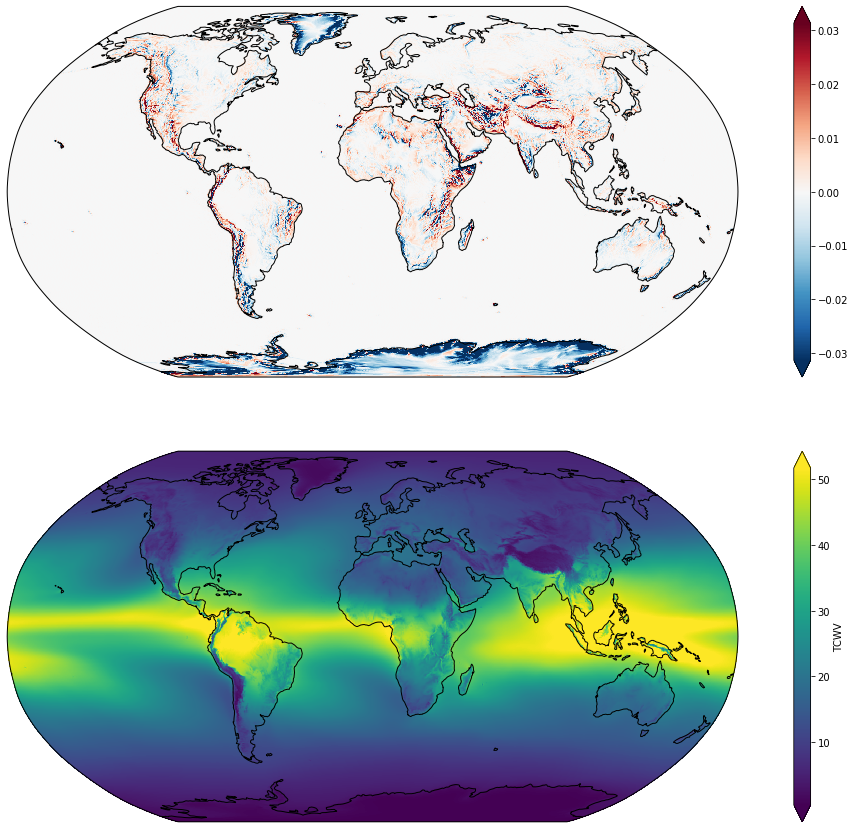

In [7]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,15),subplot_kw={'projection': ccrs.Robinson()})
upslope_w_era5_07.plot(ax=ax1,transform=ccrs.PlateCarree(),robust=True)#,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))
pw_era5_mean07.plot(ax=ax2,transform=ccrs.PlateCarree(),robust=True)

ax1.coastlines();ax2.coastlines()


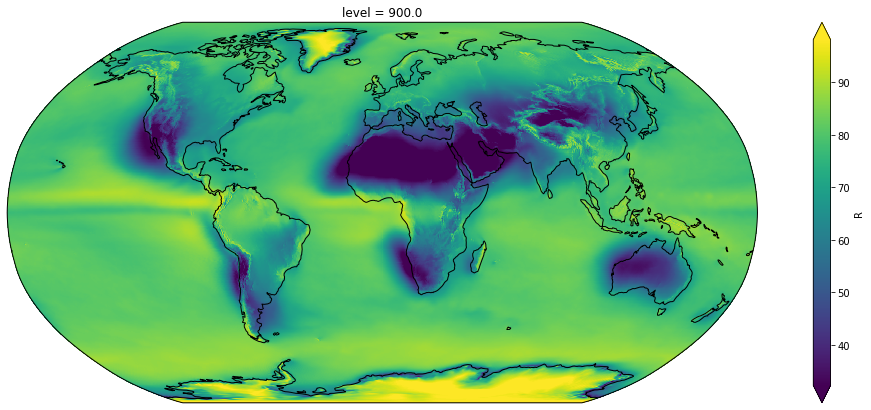

In [8]:
r_era5_mean07 = mean_era5("2010","2013",'128_157_r',mnth="").sel(level=900.)

fig, (ax1) = plt.subplots(1,1,figsize=(20,7),subplot_kw={'projection': ccrs.Robinson()})
r_era5_mean07.plot(ax=ax1,transform=ccrs.PlateCarree(),robust=True)#,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))

ax1.coastlines()
